In [19]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [20]:
from PIL import Image

In [21]:
class DQN(nn.Module):
    def __init__(self, input_dims, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4 , out_channels=20 , kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=20 , out_channels=16 , kernel_size=8)
        
        self.fc1 = nn.Linear(in_features=16*11*11, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=6)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = self.conv2(t)  
        t = F.relu(t)
        t = F.max_pool2d(t ,kernel_size=2 ,stride=2)
        
        t = t.reshape(-1,16*11*11) 
        t = self.fc1(t)
        
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.fc3(t)
        return t

In [22]:
class Agent():
    def __init__(self, gamma, eps, eps_min, eps_decay, num_actions, device):
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, rate, state, policy_net):
        if random.random() > rate:
            obs = torch.tensor([state], dtype=torch.float32).to(self.device)
            #print(obs.shape)
            return policy_net(obs).argmax(dim=1).item()
        else:
            return np.random.choice(self.num_actions)
        

In [23]:
random.random()

0.7803769335770543

In [24]:
class ReplayMemory():
    def __init__(self, capacity, batch_size, input_dims, eps, eps_min, eps_decay, image_set):
        self.capacity = capacity
        self.batch_size = batch_size
        self.state_memory  = np.zeros((capacity, image_set, 64, 64), dtype=np.float32)
        self.action_memory = np.zeros(capacity, dtype=np.int32)
        self.reward_memory = np.zeros(capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((capacity, image_set, 64, 64), dtype=np.float32)
        self.terminal_memory = np.zeros(capacity, dtype=np.bool)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.experience_ctr = 0
        self.image_set = image_set
        
    def store(self, state, action, reward, next_state, terminal):
        index = self.experience_ctr % self.capacity
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = terminal
        self.experience_ctr += 1
        
    def can_provide_batch(self):
        return self.experience_ctr >= batch_size
    
    def give_batch(self):
        length = min(self.experience_ctr, self.capacity)
        batch = np.random.choice(length, self.batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]
        return (states, actions, rewards, next_states, terminals)
    
    def get_epsilon(self):
        #print(self.experience_ctr)
        rate = self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.experience_ctr / self.eps_decay)
        return rate
    
    def rgb2gray(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    def preprocess(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        im = Image.fromarray(gray)
        im = im.resize((64,64)) 
        gray = np.array(im)
        return gray
    
    def first_visit(self, image):
        gray_image = self.preprocess(image)
        gray_set = []
        for _ in range(self.image_set):
            gray_set.append(gray_image)
        gray_set = np.array(gray_set)
        #print(gray_set.shape)
        #gray_set = np.rollaxis(gray_set ,2)
        #print(gray_set.shape)
        return gray_set
    
    def next_stack(self, action, image_set, env):
        reward_total = 0
        gray_set = []
        terminal = False
        for _ in range(image_set):
            if terminal==False:
                next_state, reward, terminal, emp = env.step(action)
                reward_total += reward
            image = env.render(mode = 'rgb_array')/255
            #env.close()
            gray_image = self.preprocess(image)
            gray_set.append(gray_image)
        gray_set = np.array(gray_set)
        #gray_set = np.rollaxis(gray_set ,2)
        return gray_set, reward_total, terminal, emp
        

In [25]:
batch_size = 64
gamma = 0.999
eps = 0.9
eps_min = 0.05
eps_decay = 1000
update_rate = 10
capacity = 50000
lr = 0.001
input_dims = 4
num_episodes = 800
image_set = 4
num_actions = 6

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
policy_net = DQN(input_dims, lr).to(device)
target_net = DQN(input_dims, lr).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(4, 20, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(20, 16, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
  (loss): MSELoss()
)

In [28]:
agent = Agent(gamma, eps, eps_min, eps_decay, num_actions, device)
memory = ReplayMemory(capacity, batch_size, 4, eps, eps_min, eps_decay, image_set)

/tmp/ipykernel_3584/2994347657.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(capacity, dtype=np.bool)


In [29]:
env = gym.make('Pong-v0')
print(env.observation_space)
env.action_space
#env.reset()

Box(0, 255, (210, 160, 3), uint8)


Discrete(6)

In [30]:
def get_tensors(batch, device):
    states = torch.tensor(batch[0]).to(device)
    actions = batch[1]
    rewards = torch.tensor(batch[2]).to(device)
    next_states = torch.tensor(batch[3]).to(device)
    dones = torch.tensor(batch[4]).to(device)
    return states, actions, rewards, next_states, dones

In [31]:
score_track = []
eps_track = []
loss_track = []
batch_index = np.arange(batch_size, dtype = np.int32)
for episode in range(num_episodes):
    print(episode)
    score = 0
    terminal = False
    env.reset()
    image = env.render(mode = 'rgb_array')/255
    #env.close()
    state = memory.first_visit(image)
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(rate, state, policy_net)
        next_state, reward, terminal, emp = memory.next_stack(action, image_set, env)
        #next_state, reward, terminal, emp = env.step(action)
        memory.store(state, action, reward, next_state, terminal)
        state = next_state.copy()
        score += reward
        
        if memory.can_provide_batch():
            batch = memory.give_batch()
            states, actions, rewards, next_states, dones = get_tensors(batch, device)
            
            current_q_values = policy_net.forward(states)[batch_index, actions]
            current_q_values = current_q_values.reshape(-1,1)
            next_q_values = target_net.forward(next_states)
            next_q_values[dones] = 0.0
            next_q_values = torch.max(next_q_values, dim=1)[0].detach()
            
            target_q_values = (gamma * next_q_values) + rewards
            target_q_values = target_q_values.reshape(-1,1)
            #print(current_q_values.shape, next_q_values.shape, rewards.shape)
            policy_net.optimizer.zero_grad()
            loss = policy_net.loss(target_q_values, current_q_values)
            loss_track.append(loss.item())
            loss.backward()
            policy_net.optimizer.step()
            
    score_track.append(score)
    if episode%update_rate==0:
        target_net.load_state_dict(policy_net.state_dict())
env.close()

0


/home/tanmayp/Desktop/virenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


KeyboardInterrupt: 

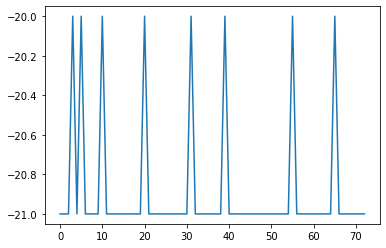

In [32]:
x = range(len(score_track))
plt.plot(x, score_track)

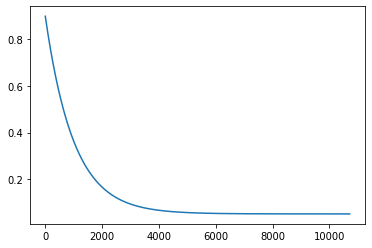

In [41]:
x = range(len(eps_track))
plt.plot(x, eps_track)

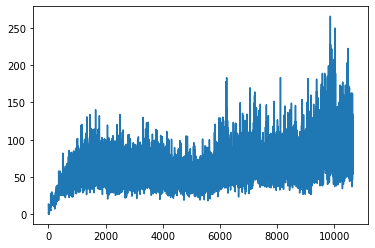

In [42]:
x = range(len(loss_track))
plt.plot(x, loss_track)

In [43]:
state = env.reset()
score = 0
done = False
avg_score = []
avg_score_track = []
for i in range(20):
    score = 0
    terminal = False
    env.reset()
    image = env.render(mode = 'rgb_array')/255
    #env.close()
    state = memory.first_visit(image)
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(0, state, policy_net)
        next_state, reward, terminal, emp = memory.next_stack(action, image_set, env)
        #next_state, reward, terminal, emp = env.step(action)
        #memory.store(state, action, reward, next_state, terminal)
        state = next_state.copy()
        score += reward
    
    avg_score.append(score)
env.close()
print(np.mean(avg_score))    
#a = torch.tensor([[1,2,3,4], [1,1,1,1]], dtype=torch.float32).to(device)
#b = policy_net(a)
#print(b, b.shape)

111.9


In [18]:
env.reset()
image = env.render(mode = 'rgb_array')/255
env.close()

In [19]:
r = ReplayMemory(capacity, batch_size, 4, eps, eps_min, eps_decay, image_set)

In [20]:
r.first_visit(image)

array([[[0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        ...,
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999]],

       [[0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        ...,
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999]],

       [[0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        [0.9999, 0.9999, 0.9999, ..., 0.9999, 0.9999, 0.9999],
        ...,
        [0.9